# feed forward NN with one hidden layer

In [61]:
import os
import sys
import timeit

import numpy

import theano
import theano.tensor as T
from theano.tensor.signal import pool
from theano.tensor.nnet import conv2d
from logistic_sgd import LogisticRegression, load_data
#from mlp import HiddenLayer

In [62]:
class baseHiddenLayer(object):
    def __init__(self, rng, input, n_in, n_out, activation=T.nnet.relu):
        self.input = input
        self.mu = theano.shared(value = 0.0, name='mu')
        self.sigma = theano.shared(value = 1.0, name='sigma')
        self.n_in = n_in
        self.n_out = n_out
        self.init_W = rng.normal(0,1,size=(self.n_in, self.n_out))
        self.init_W = numpy.asarray(self.init_W, dtype=theano.config.floatX)
        self.W = theano.shared(value=self.init_W, name='W')
        b_values = numpy.zeros((n_out,), dtype=theano.config.floatX)
        self.b = theano.shared(value=b_values, name='b')
        lin_output = T.dot(input, self.W)
        self.output = activation(lin_output + self.b)
        self.params = [self.W, self.b]

In [63]:
class distributionHiddenLayer(baseHiddenLayer):
    def __init__(self, rng, input, n_in, n_out, activation=T.nnet.relu):
        self.input = input
        self.mu = theano.shared(value = numpy.asarray(0.0, dtype = theano.config.floatX), name='mu')
        self.sigma = theano.shared(value = numpy.asarray(1.0, dtype = theano.config.floatX), name='sigma')
        self.n_in = n_in
        self.n_out = n_out
        self.init_W = rng.normal(0,1,size=(self.n_in, self.n_out))
        self.init_W = numpy.asarray(self.init_W, dtype=theano.config.floatX)
        self.W = (self.init_W + self.mu) * self.sigma
        b_values = numpy.zeros((n_out,), dtype=theano.config.floatX)
        self.b = theano.shared(value=b_values, name='b')
        lin_output = T.dot(input, self.W)
        self.output = activation(lin_output + self.b)
        self.params = [self.mu, self.sigma, self.b]

In [64]:
batch_size = 1000
rng = numpy.random.RandomState(2345)
datasets = load_data('mnist.pkl.gz')
train_set_x, train_set_y = datasets[0]
valid_set_x, valid_set_y = datasets[1]
test_set_x, test_set_y = datasets[2]
# compute number of minibatches for training, validation and testing
n_train_batches = train_set_x.get_value(borrow=True).shape[0]
n_valid_batches = valid_set_x.get_value(borrow=True).shape[0]
n_test_batches = test_set_x.get_value(borrow=True).shape[0]
n_train_batches //= batch_size
n_valid_batches //= batch_size
n_test_batches //= batch_size
# allocate symbolic variables for the data
index = T.lscalar()  # index to a [mini]batch
# start-snippet-1
x = T.matrix('x')   # the data is presented as rasterized images
y = T.ivector('y')  # the labels are presented as 1D vector of
print('... building the model')

... loading data
... building the model


In [65]:
layer0_input = x.reshape((batch_size, 784))
layer0 = baseHiddenLayer(rng,input=layer0_input,n_in = 784,n_out = 500)
layer1 = LogisticRegression(input = layer0.output, n_in=500, n_out=10)
cost = layer1.negative_log_likelihood(y)
learning_rate = 0.01
n_epochs = 200

# train full param

In [66]:
test_model = theano.function(
    [index],
    layer1.errors(y),
    givens={
        x: test_set_x[index * batch_size: (index + 1) * batch_size],
        y: test_set_y[index * batch_size: (index + 1) * batch_size]
    }
)

validate_model = theano.function(
    [index],
    layer1.errors(y),
    givens={
        x: valid_set_x[index * batch_size: (index + 1) * batch_size],
        y: valid_set_y[index * batch_size: (index + 1) * batch_size]
    }
)

params = layer1.params + layer0.params
grads = T.grad(cost, params)
updates = [
    (param_i, param_i - learning_rate * grad_i)
    for param_i, grad_i in zip(params, grads)
]
train_model = theano.function(
    [index],
    cost,
    updates=updates,
    givens={
        x: train_set_x[index * batch_size: (index + 1) * batch_size],
        y: train_set_y[index * batch_size: (index + 1) * batch_size]
    }
)

In [67]:
validation_frequency = n_train_batches
best_validation_loss = numpy.inf
best_iter = 0
test_score = 0.
start_time = timeit.default_timer()

epoch = 0
done_looping = False
valid_acc = []

while (epoch < n_epochs):
    epoch = epoch + 1
    for minibatch_index in range(n_train_batches):
        iter = (epoch - 1) * n_train_batches + minibatch_index

        if iter % 100 == 0:
            print('training @ iter = ', iter)
        cost_ij = train_model(minibatch_index)

        if (iter + 1) % validation_frequency == 0:

            # compute zero-one loss on validation set
            validation_losses = [validate_model(i) for i
                                 in range(n_valid_batches)]
            this_validation_loss = numpy.mean(validation_losses)
            valid_acc.append(this_validation_loss)
            print('epoch %i, minibatch %i/%i, validation error %f %%' %
                  (epoch, minibatch_index + 1, n_train_batches,
                   this_validation_loss * 100.))

            # if we got the best validation score until now
            if this_validation_loss < best_validation_loss:
                # save best validation score and iteration number
                best_validation_loss = this_validation_loss
                best_iter = iter
                # test it on the test set
                test_losses = [
                    test_model(i)
                    for i in range(n_test_batches)
                ]
                test_score = numpy.mean(test_losses)
                print(('     epoch %i, minibatch %i/%i, test error of '
                       'best model %f %%') %
                      (epoch, minibatch_index + 1, n_train_batches,
                       test_score * 100.))
end_time = timeit.default_timer()
print('Optimization complete.')
print('Best validation score of %f %% obtained at iteration %i, '
      'with test performance %f %%' %
      (best_validation_loss * 100., best_iter + 1, test_score * 100.))

training @ iter =  0
epoch 1, minibatch 50/50, validation error 13.890000 %
     epoch 1, minibatch 50/50, test error of best model 14.550000 %
epoch 2, minibatch 50/50, validation error 11.050000 %
     epoch 2, minibatch 50/50, test error of best model 11.300000 %
training @ iter =  100
epoch 3, minibatch 50/50, validation error 11.970000 %
epoch 4, minibatch 50/50, validation error 7.910000 %
     epoch 4, minibatch 50/50, test error of best model 7.880000 %
training @ iter =  200
epoch 5, minibatch 50/50, validation error 8.680000 %
epoch 6, minibatch 50/50, validation error 7.310000 %
     epoch 6, minibatch 50/50, test error of best model 7.680000 %
training @ iter =  300
epoch 7, minibatch 50/50, validation error 7.530000 %
epoch 8, minibatch 50/50, validation error 15.790000 %
training @ iter =  400
epoch 9, minibatch 50/50, validation error 6.430000 %
     epoch 9, minibatch 50/50, test error of best model 6.800000 %
epoch 10, minibatch 50/50, validation error 6.500000 %
train

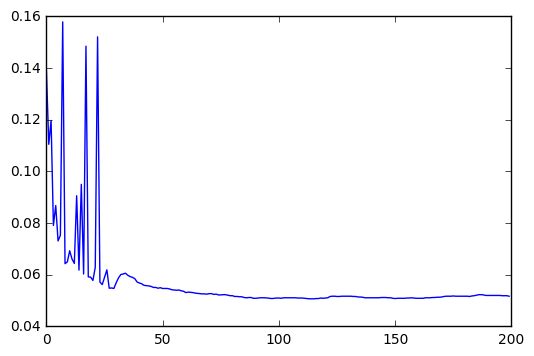

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(numpy.arange(len(valid_acc)), valid_acc)

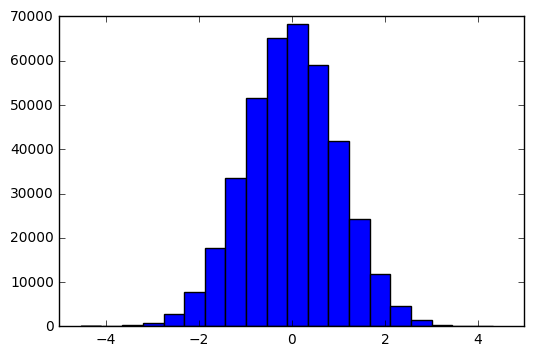

In [83]:
_,_,_ = plt.hist(layer0.W.get_value().flatten(), 20)
plt.show()

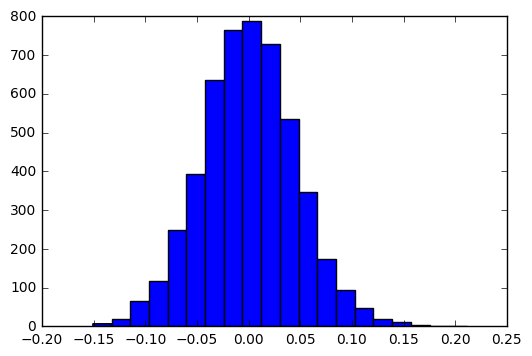

In [82]:
n, bins, patches = plt.hist(layer1.W.get_value().flatten(), 20)
plt.show()

# train distribution of the hidden layer with unified lambda


In [84]:
layer0_input = x.reshape((batch_size, 784))
layer0 = distributionHiddenLayer(rng,input=layer0_input,n_in = 784,n_out = 500)
layer1 = LogisticRegression(input = layer0.output, n_in=500, n_out=10)
cost = layer1.negative_log_likelihood(y)
learning_rate = 1e-5
n_epochs = 200
test_model = theano.function(
    [index],
    layer1.errors(y),
    givens={
        x: test_set_x[index * batch_size: (index + 1) * batch_size],
        y: test_set_y[index * batch_size: (index + 1) * batch_size]
    }
)

validate_model = theano.function(
    [index],
    layer1.errors(y),
    givens={
        x: valid_set_x[index * batch_size: (index + 1) * batch_size],
        y: valid_set_y[index * batch_size: (index + 1) * batch_size]
    }
)

params = layer1.params + layer0.params
grads = T.grad(cost, params)
updates = [
    (param_i, param_i - learning_rate * grad_i)
    for param_i, grad_i in zip(params, grads)
]
train_model = theano.function(
    [index],
    cost,
    updates=updates,
    givens={
        x: train_set_x[index * batch_size: (index + 1) * batch_size],
        y: train_set_y[index * batch_size: (index + 1) * batch_size]
    }
)

In [85]:
validation_frequency = n_train_batches
best_validation_loss = numpy.inf
best_iter = 0
test_score = 0.
start_time = timeit.default_timer()

epoch = 0
done_looping = False
valid_acc = []

while (epoch < n_epochs):
    epoch = epoch + 1
    for minibatch_index in range(n_train_batches):
        iter = (epoch - 1) * n_train_batches + minibatch_index

        if iter % 100 == 0:
            print('training @ iter = ', iter)
        cost_ij = train_model(minibatch_index)

        if (iter + 1) % validation_frequency == 0:

            # compute zero-one loss on validation set
            validation_losses = [validate_model(i) for i
                                 in range(n_valid_batches)]
            this_validation_loss = numpy.mean(validation_losses)
            valid_acc.append(this_validation_loss)
            print('epoch %i, minibatch %i/%i, validation error %f %%' %
                  (epoch, minibatch_index + 1, n_train_batches,
                   this_validation_loss * 100.))

            # if we got the best validation score until now
            if this_validation_loss < best_validation_loss:
                # save best validation score and iteration number
                best_validation_loss = this_validation_loss
                best_iter = iter
                # test it on the test set
                test_losses = [
                    test_model(i)
                    for i in range(n_test_batches)
                ]
                test_score = numpy.mean(test_losses)
                print(('     epoch %i, minibatch %i/%i, test error of '
                       'best model %f %%') %
                      (epoch, minibatch_index + 1, n_train_batches,
                       test_score * 100.))
end_time = timeit.default_timer()
print('Optimization complete.')
print('Best validation score of %f %% obtained at iteration %i, '
      'with test performance %f %%' %
      (best_validation_loss * 100., best_iter + 1, test_score * 100.))

training @ iter =  0
epoch 1, minibatch 50/50, validation error 35.500000 %
     epoch 1, minibatch 50/50, test error of best model 37.640000 %
epoch 2, minibatch 50/50, validation error 29.780000 %
     epoch 2, minibatch 50/50, test error of best model 31.570000 %
training @ iter =  100
epoch 3, minibatch 50/50, validation error 27.070000 %
     epoch 3, minibatch 50/50, test error of best model 28.560000 %
epoch 4, minibatch 50/50, validation error 25.670000 %
     epoch 4, minibatch 50/50, test error of best model 26.780000 %
training @ iter =  200
epoch 5, minibatch 50/50, validation error 24.490000 %
     epoch 5, minibatch 50/50, test error of best model 25.410000 %
epoch 6, minibatch 50/50, validation error 23.410000 %
     epoch 6, minibatch 50/50, test error of best model 24.350000 %
training @ iter =  300
epoch 7, minibatch 50/50, validation error 22.560000 %
     epoch 7, minibatch 50/50, test error of best model 23.330000 %
epoch 8, minibatch 50/50, validation error 21.660

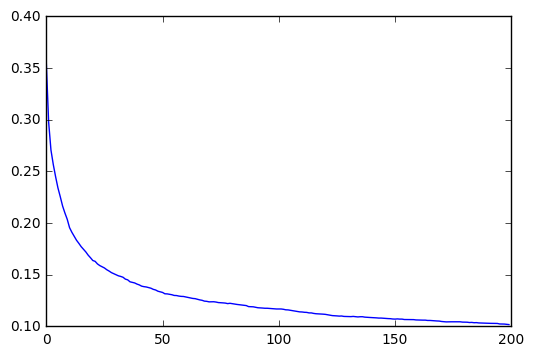

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(numpy.arange(len(valid_acc)), valid_acc)

In [87]:
print('mu:{}\t sigma:{}'.format(layer0.mu.get_value(), layer0.sigma.get_value()))

mu:0.10293424129486084	 sigma:1.03816819190979


In [88]:
layer0.init_W

array([[-1.66723716,  1.66828465, -0.03546967, ..., -0.37416509,
         0.60873008, -1.6586293 ],
       [ 2.03067589,  0.14495799, -1.09295964, ..., -1.83208418,
        -0.38337886,  1.36431634],
       [-0.13468155,  0.19831567, -0.14509408, ...,  0.73648846,
        -0.35706189,  2.04183793],
       ..., 
       [-0.53663135,  2.30793667,  2.15695286, ...,  0.73536378,
        -0.22523226,  1.0134145 ],
       [ 1.72721112, -0.91718614,  0.83314782, ...,  0.57249767,
        -0.68502986,  0.49345851],
       [ 0.11139331,  2.34756231, -1.18504834, ..., -0.45629728,
         1.21909785,  0.6935553 ]], dtype=float32)

In [89]:
theano.pp(layer0.W)

'((TensorConstant{[[-1.66723..6935553 ]]} + mu) * sigma)'

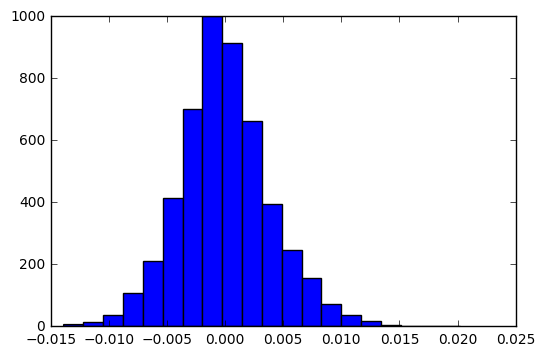

In [90]:
n, bins, patches = plt.hist(layer1.W.get_value().flatten(), 20)
plt.show()

# train with different lambda for each layer.

In [98]:
layer0_input = x.reshape((batch_size, 784))
layer0 = distributionHiddenLayer(rng,input=layer0_input,n_in = 784,n_out = 500)
layer1 = LogisticRegression(input = layer0.output, n_in=500, n_out=10)
cost = layer1.negative_log_likelihood(y)
learning_rate = 0.01
n_epochs = 200
test_model = theano.function(
    [index],
    layer1.errors(y),
    givens={
        x: test_set_x[index * batch_size: (index + 1) * batch_size],
        y: test_set_y[index * batch_size: (index + 1) * batch_size]
    }
)

validate_model = theano.function(
    [index],
    layer1.errors(y),
    givens={
        x: valid_set_x[index * batch_size: (index + 1) * batch_size],
        y: valid_set_y[index * batch_size: (index + 1) * batch_size]
    }
)

grads_1 = T.grad(cost, layer1.params)
updates = [
    (param_i, param_i - learning_rate * grad_i)
    for param_i, grad_i in zip(layer1.params, grads_1)
]
updates.append((layer0.mu, layer0.mu - 1/1000*learning_rate*T.grad(cost, layer0.mu)))
updates.append((layer0.sigma, layer0.sigma - 1/1000*learning_rate*T.grad(cost, layer0.sigma)))
updates.append((layer0.b, layer0.b - learning_rate*T.grad(cost, layer0.b)))

train_model = theano.function(
    [index],
    cost,
    updates=updates,
    givens={
        x: train_set_x[index * batch_size: (index + 1) * batch_size],
        y: train_set_y[index * batch_size: (index + 1) * batch_size]
    }
)

In [99]:
validation_frequency = n_train_batches
best_validation_loss = numpy.inf
best_iter = 0
test_score = 0.
start_time = timeit.default_timer()

epoch = 0
done_looping = False
valid_acc = []

while (epoch < n_epochs):
    epoch = epoch + 1
    for minibatch_index in range(n_train_batches):
        iter = (epoch - 1) * n_train_batches + minibatch_index

        if iter % 100 == 0:
            print('training @ iter = ', iter)
        cost_ij = train_model(minibatch_index)

        if (iter + 1) % validation_frequency == 0:

            # compute zero-one loss on validation set
            validation_losses = [validate_model(i) for i
                                 in range(n_valid_batches)]
            this_validation_loss = numpy.mean(validation_losses)
            valid_acc.append(this_validation_loss)
            print('epoch %i, minibatch %i/%i, validation error %f %%' %
                  (epoch, minibatch_index + 1, n_train_batches,
                   this_validation_loss * 100.))

            # if we got the best validation score until now
            if this_validation_loss < best_validation_loss:
                # save best validation score and iteration number
                best_validation_loss = this_validation_loss
                best_iter = iter
                # test it on the test set
                test_losses = [
                    test_model(i)
                    for i in range(n_test_batches)
                ]
                test_score = numpy.mean(test_losses)
                print(('     epoch %i, minibatch %i/%i, test error of '
                       'best model %f %%') %
                      (epoch, minibatch_index + 1, n_train_batches,
                       test_score * 100.))
end_time = timeit.default_timer()
print('Optimization complete.')
print('Best validation score of %f %% obtained at iteration %i, '
      'with test performance %f %%' %
      (best_validation_loss * 100., best_iter + 1, test_score * 100.))

training @ iter =  0
epoch 1, minibatch 50/50, validation error 11.210000 %
     epoch 1, minibatch 50/50, test error of best model 11.940000 %
epoch 2, minibatch 50/50, validation error 9.600000 %
     epoch 2, minibatch 50/50, test error of best model 9.890000 %
training @ iter =  100
epoch 3, minibatch 50/50, validation error 10.820000 %
epoch 4, minibatch 50/50, validation error 9.030000 %
     epoch 4, minibatch 50/50, test error of best model 9.220000 %
training @ iter =  200
epoch 5, minibatch 50/50, validation error 7.530000 %
     epoch 5, minibatch 50/50, test error of best model 8.050000 %
epoch 6, minibatch 50/50, validation error 7.600000 %
training @ iter =  300
epoch 7, minibatch 50/50, validation error 7.340000 %
     epoch 7, minibatch 50/50, test error of best model 7.760000 %
epoch 8, minibatch 50/50, validation error 7.010000 %
     epoch 8, minibatch 50/50, test error of best model 7.410000 %
training @ iter =  400
epoch 9, minibatch 50/50, validation error 6.83000

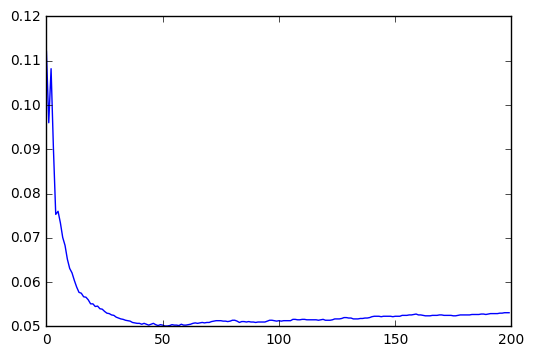

In [104]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(numpy.arange(len(valid_acc)), valid_acc)

In [100]:
print('mu:{}\t sigma:{}'.format(layer0.mu.get_value(), layer0.sigma.get_value()))

mu:-0.010360423475503922	 sigma:1.0019110441207886


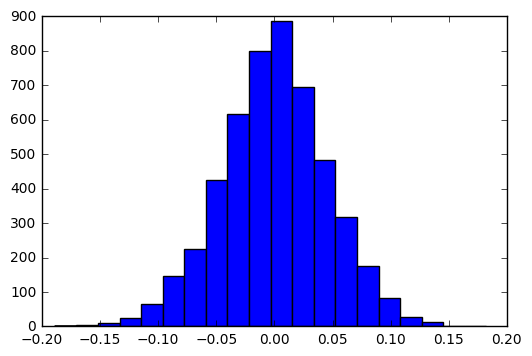

In [103]:
n, bins, patches = plt.hist(layer1.W.get_value().flatten(), 20)
plt.show()

# don't train layer0 at all.

In [105]:
layer0_input = x.reshape((batch_size, 784))
layer0 = distributionHiddenLayer(rng,input=layer0_input,n_in = 784,n_out = 500)
layer1 = LogisticRegression(input = layer0.output, n_in=500, n_out=10)
cost = layer1.negative_log_likelihood(y)
learning_rate = 0.01
n_epochs = 200
test_model = theano.function(
    [index],
    layer1.errors(y),
    givens={
        x: test_set_x[index * batch_size: (index + 1) * batch_size],
        y: test_set_y[index * batch_size: (index + 1) * batch_size]
    }
)

validate_model = theano.function(
    [index],
    layer1.errors(y),
    givens={
        x: valid_set_x[index * batch_size: (index + 1) * batch_size],
        y: valid_set_y[index * batch_size: (index + 1) * batch_size]
    }
)

grads_1 = T.grad(cost, layer1.params)
updates = [
    (param_i, param_i - learning_rate * grad_i)
    for param_i, grad_i in zip(layer1.params, grads_1)
]
train_model = theano.function(
    [index],
    cost,
    updates=updates,
    givens={
        x: train_set_x[index * batch_size: (index + 1) * batch_size],
        y: train_set_y[index * batch_size: (index + 1) * batch_size]
    }
)

In [106]:
validation_frequency = n_train_batches
best_validation_loss = numpy.inf
best_iter = 0
test_score = 0.
start_time = timeit.default_timer()

epoch = 0
done_looping = False
valid_acc = []

while (epoch < n_epochs):
    epoch = epoch + 1
    for minibatch_index in range(n_train_batches):
        iter = (epoch - 1) * n_train_batches + minibatch_index

        if iter % 100 == 0:
            print('training @ iter = ', iter)
        cost_ij = train_model(minibatch_index)

        if (iter + 1) % validation_frequency == 0:

            # compute zero-one loss on validation set
            validation_losses = [validate_model(i) for i
                                 in range(n_valid_batches)]
            this_validation_loss = numpy.mean(validation_losses)
            valid_acc.append(this_validation_loss)
            print('epoch %i, minibatch %i/%i, validation error %f %%' %
                  (epoch, minibatch_index + 1, n_train_batches,
                   this_validation_loss * 100.))

            # if we got the best validation score until now
            if this_validation_loss < best_validation_loss:
                # save best validation score and iteration number
                best_validation_loss = this_validation_loss
                best_iter = iter
                # test it on the test set
                test_losses = [
                    test_model(i)
                    for i in range(n_test_batches)
                ]
                test_score = numpy.mean(test_losses)
                print(('     epoch %i, minibatch %i/%i, test error of '
                       'best model %f %%') %
                      (epoch, minibatch_index + 1, n_train_batches,
                       test_score * 100.))
end_time = timeit.default_timer()
print('Optimization complete.')
print('Best validation score of %f %% obtained at iteration %i, '
      'with test performance %f %%' %
      (best_validation_loss * 100., best_iter + 1, test_score * 100.))

training @ iter =  0
epoch 1, minibatch 50/50, validation error 12.730000 %
     epoch 1, minibatch 50/50, test error of best model 13.600000 %
epoch 2, minibatch 50/50, validation error 17.080000 %
training @ iter =  100
epoch 3, minibatch 50/50, validation error 12.970000 %
epoch 4, minibatch 50/50, validation error 19.540000 %
training @ iter =  200
epoch 5, minibatch 50/50, validation error 13.740000 %
epoch 6, minibatch 50/50, validation error 9.100000 %
     epoch 6, minibatch 50/50, test error of best model 9.380000 %
training @ iter =  300
epoch 7, minibatch 50/50, validation error 9.290000 %
epoch 8, minibatch 50/50, validation error 18.740000 %
training @ iter =  400
epoch 9, minibatch 50/50, validation error 11.380000 %
epoch 10, minibatch 50/50, validation error 19.930000 %
training @ iter =  500
epoch 11, minibatch 50/50, validation error 9.780000 %
epoch 12, minibatch 50/50, validation error 9.310000 %
training @ iter =  600
epoch 13, minibatch 50/50, validation error 13.

# layer0 starts from zero.

In [115]:
class baseHiddenLayer(object):
    def __init__(self, rng, input, n_in, n_out, activation=T.nnet.relu):
        self.input = input
        self.mu = theano.shared(value = 0.0, name='mu')
        self.sigma = theano.shared(value = 1.0, name='sigma')
        self.n_in = n_in
        self.n_out = n_out
        self.init_W = rng.normal(0,0.01,size=(self.n_in, self.n_out))
        self.init_W = numpy.asarray(self.init_W, dtype=theano.config.floatX)
        self.W = theano.shared(value=self.init_W, name='W')
        b_values = numpy.zeros((n_out,), dtype=theano.config.floatX)
        self.b = theano.shared(value=b_values, name='b')
        lin_output = T.dot(input, self.W)
        self.output = activation(lin_output + self.b)
        self.params = [self.W, self.b]
layer0_input = x.reshape((batch_size, 784))
layer0 = baseHiddenLayer(rng,input=layer0_input,n_in = 784,n_out = 500)
layer1 = LogisticRegression(input = layer0.output, n_in=500, n_out=10)
cost = layer1.negative_log_likelihood(y)
learning_rate = 0.01
n_epochs = 200
test_model = theano.function(
    [index],
    layer1.errors(y),
    givens={
        x: test_set_x[index * batch_size: (index + 1) * batch_size],
        y: test_set_y[index * batch_size: (index + 1) * batch_size]
    }
)

validate_model = theano.function(
    [index],
    layer1.errors(y),
    givens={
        x: valid_set_x[index * batch_size: (index + 1) * batch_size],
        y: valid_set_y[index * batch_size: (index + 1) * batch_size]
    }
)

params = layer1.params + layer0.params
grads = T.grad(cost, params)
updates = [
    (param_i, param_i - learning_rate * grad_i)
    for param_i, grad_i in zip(params, grads)
]
train_model = theano.function(
    [index],
    cost,
    updates=updates,
    givens={
        x: train_set_x[index * batch_size: (index + 1) * batch_size],
        y: train_set_y[index * batch_size: (index + 1) * batch_size]
    }
)

In [116]:
validation_frequency = n_train_batches
best_validation_loss = numpy.inf
best_iter = 0
test_score = 0.
start_time = timeit.default_timer()

epoch = 0
done_looping = False
valid_acc = []

while (epoch < n_epochs):
    epoch = epoch + 1
    for minibatch_index in range(n_train_batches):
        iter = (epoch - 1) * n_train_batches + minibatch_index

        if iter % 100 == 0:
            print('training @ iter = ', iter)
        cost_ij = train_model(minibatch_index)

        if (iter + 1) % validation_frequency == 0:

            # compute zero-one loss on validation set
            validation_losses = [validate_model(i) for i
                                 in range(n_valid_batches)]
            this_validation_loss = numpy.mean(validation_losses)
            valid_acc.append(this_validation_loss)
            print('epoch %i, minibatch %i/%i, validation error %f %%' %
                  (epoch, minibatch_index + 1, n_train_batches,
                   this_validation_loss * 100.))

            # if we got the best validation score until now
            if this_validation_loss < best_validation_loss:
                # save best validation score and iteration number
                best_validation_loss = this_validation_loss
                best_iter = iter
                # test it on the test set
                test_losses = [
                    test_model(i)
                    for i in range(n_test_batches)
                ]
                test_score = numpy.mean(test_losses)
                print(('     epoch %i, minibatch %i/%i, test error of '
                       'best model %f %%') %
                      (epoch, minibatch_index + 1, n_train_batches,
                       test_score * 100.))
end_time = timeit.default_timer()
print('Optimization complete.')
print('Best validation score of %f %% obtained at iteration %i, '
      'with test performance %f %%' %
      (best_validation_loss * 100., best_iter + 1, test_score * 100.))

training @ iter =  0
epoch 1, minibatch 50/50, validation error 52.300000 %
     epoch 1, minibatch 50/50, test error of best model 52.760000 %
epoch 2, minibatch 50/50, validation error 51.640000 %
     epoch 2, minibatch 50/50, test error of best model 52.370000 %
training @ iter =  100
epoch 3, minibatch 50/50, validation error 51.710000 %
epoch 4, minibatch 50/50, validation error 51.780000 %
training @ iter =  200
epoch 5, minibatch 50/50, validation error 50.520000 %
     epoch 5, minibatch 50/50, test error of best model 51.440000 %
epoch 6, minibatch 50/50, validation error 47.080000 %
     epoch 6, minibatch 50/50, test error of best model 48.070000 %
training @ iter =  300
epoch 7, minibatch 50/50, validation error 41.590000 %
     epoch 7, minibatch 50/50, test error of best model 42.760000 %
epoch 8, minibatch 50/50, validation error 35.880000 %
     epoch 8, minibatch 50/50, test error of best model 37.110000 %
training @ iter =  400
epoch 9, minibatch 50/50, validation er

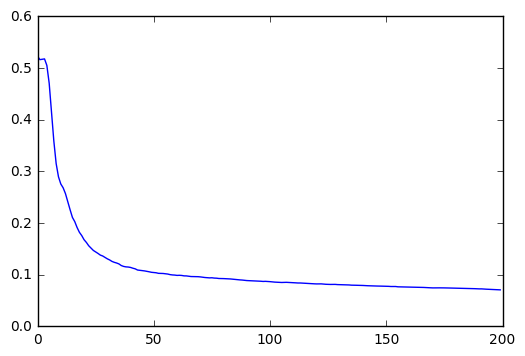

In [117]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(numpy.arange(len(valid_acc)), valid_acc)

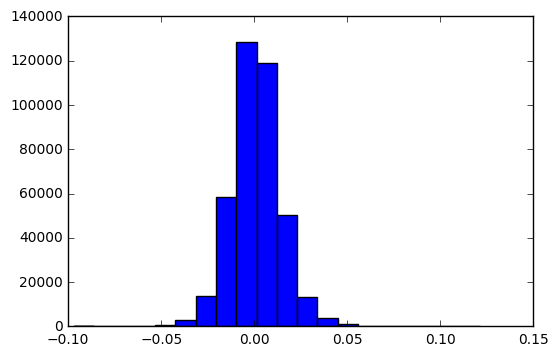

In [118]:
_,_,_ = plt.hist(layer0.W.get_value().flatten(), 20)
plt.show()

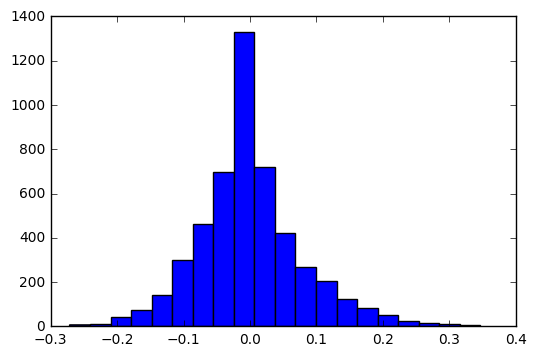

In [119]:
_,_,_ = plt.hist(layer1.W.get_value().flatten(), 20)
plt.show()